# PyRitz Tutorial

This tutorial is a guide through the process of using PyRitz to find the Freidlin-Wentzell instanton of Stochasic Differential Equation (SDE). As an example, we will consider the Maier-Stein system [2].

Sections 2-3 is a brief introduction to Freidlin-Wentzell theory and the PyRitz method. The reader can jump forward to section 4 if they are already familiar with it.

## 1. The Maier-Stein system

The Maier-Stein system is of the following form:

$$
dX = a(X)dt + \sqrt{\epsilon} dW.
$$

where

$$
a(x_1, x_2) =
\begin{pmatrix}
x_1 - x_1^3 - \beta x_1 x_2^2 \\
-(1 + x_1^2) x_2
\end{pmatrix}.
$$

and $\beta=10$.

The drift $a(x)$ has two stable fixed points at $x_a = (-1, 0)$ and $x_b = (1, 0)$ and a saddle fixed point at $x_s = (0, 0)$.

## 2. The geometric action

Our aim is to find the most-probable path (instanton) starting at $x_a$ and ending at $x_b$. To do this we must minimize the Freidlin-Wentzell action

$$
S_\text{FW}[x(t)] = \int_0^T \frac{1}{2} | \dot{x}(t) - a(x(t)) |^2  dt \quad (1)
$$

over both the space of paths $x(t)$ satisfying $x(0)=x_a$ and $x(T)=x_b$, as well as the total time of the process $T$. It can be shown that this minimum is always reached when $T \to \infty$. Due to the numerical issues that this causes the *geometric action*

$$
S[x(u)] = \int_{-1}^1 \left( |x'(u)||a(x(u))| - x'(u) \cdot a(x(u)) \right) du \quad (2)
$$

first found in [3], is used instead of Eq. 1. Eq. 2 has the property of being reparameterisation invariant, and thus minimising Eq. 2 only yields the *shape* or *graph*. To recover the true time-parameterisation of the instanton we must use the following relation

$$
\frac{dt}{du} = \frac{|x(u)|}{|a(x(u))|}.
$$

For a more detailed description of the theory in use here see [1].

## 3. The Ritz method

PyRitz minimises Eq. 2 using a *direct* method.

Briefly (see [1] for a more detailed description of the method), the Ritz method consists of reducing the variational problem into an optimisation problem, by representing paths with a finite number of parameters $\{\alpha_i\}_{i=0}^n$.  The path is expanded as

$$
x(u) = \frac{ \sum_{i=0}^n \frac{w_i}{u - u_i} \alpha_i } { \sum_{i=0}^n \frac{w_i}{u - u_i} } \quad (3)
$$

which satisfies $x(u_i) = a_i$, where $u_i = - \cos \left( j \pi / n \right)$ are the *Chebyshev nodes of the second kind*. $\{w_i\}_{i=0}^n$ are a set of pre-computable weights. Eq. 3 is called the *Barycentric formula*. See [4] for more details on its use, and its excellent convergence properties. Although Eq. (3) looks like a rational polynomial, it is in fact a polynomial of degree $n-1$.

The action of Eq. 3 can now be written as a function of $\{\alpha_i\}_{i=0}^n$

$$
S[x(u)] = S(\alpha_0, \alpha_1, \dots, \alpha_n).
$$

Numerically, the integral in (2) is computed using Clenshaw-Curtis quadrature

$$
S(\alpha_0, \alpha_1, \dots, \alpha_n) = \sum_{i=0}^{n_q} \omega_j L( x(v_j), x'(v_j) )
$$

where $n_q$ is the *quadrature order*, $v_j = - \cos ( j \pi / n_q )$ and $\{\omega_i\}_{i=0}^{n_q}$ are a set of pre-computable quadrature weights. Numerically it is important for $n_q \gg n$, as a rule-of-thumb we set $n_q = 10n$.

The Freidlin-Wentzell instanton is computed by numerically finding

$$
x^*(u) = \arg \inf_{ \{\alpha\}_{i=0}^n } S(\alpha_0, \alpha_1, \dots, \alpha_n)
$$

Since the Maier-Stein system is two-dimensional, we will be using a notation $\alpha_{ij}$ where $i$ refers to the dimension of the system, and $j$ to the parameter value along that dimension.

## 4. Import statements

To use PyRitz we need to import `pyritz`, `numpy` and `nlopt`.

In [1]:
# Modify path environment variables to search for the local Pyritz and NLopt installations in the repository.

import os, sys

pyritz_dir = "/".join(os.getcwd().split("/")[:-1])
nlopt_lib_dir = "%s/nlopt/lib" % pyritz_dir
nlopt_py_dir = "%s/nlopt/nlopt_py" % pyritz_dir

if "LD_LIBRARY_PATH" in os.environ:
    paths = os.environ["LD_LIBRARY_PATH"].split(":")
    paths.append(nlopt_lib_dir)
    os.environ["LD_LIBRARY_PATH"] = ":".join(paths)
else:
    os.environ["LD_LIBRARY_PATH"] = ":%s" % nlopt_lib_dir
    
sys.path.insert(0, nlopt_py_dir)
sys.path.insert(0, pyritz_dir)

# Import statements

import pyritz
import numpy as np
import nlopt

## 5. Defining the Maier-Stein system

The first thing we must do is to define variables for the system parameter $\beta$ and the fixed points $x_a$, $x_b$ and $x_s$.

```python
# System parameters

m_beta = 10

# Fixed points

e_xa = np.array([-1, 0])
e_xb = np.array([1,  0])
e_xs = np.array([0,  0])

```

### The `lagrangian` function

PyRitz can compute the action of a path given the Lagrangian of its system. In other words, given a function $L(x, x', u)$, PyRitz computes

$$
S[x(u)] = \int_{-1}^{1} L(x(u), x'(u), u) du \approx \sum_{i=0}^{n_q} \omega_j L( x(v_j), x'(v_j) )
$$

where $n_q$ is the quadrature order (Note: PyRitz always uses $[-1, 1]$ as the limits of integration). We supply this information to PyRitz by passing a function

```python
def lagrangian(ls, dxls, dvls, path, us, args):
    ...
```

- `us` is a 1D NumPy array of size `nq`, which contains the times $t \in [-1, 1]$ at which the Lagrangian should be evaluated at.
- `ls` is a 1D NumPy array of size `nq`. The function should assign the values of the Lagrangian at the times `us` to `ls`. In other words `ls[i]` should be assigned the value $L(x(u_i), x'(u_i), u_i)$.
- `path` is a tuple containing `(xs, vs)`.
    - `xs` is a NumPy array of shape `(dim, nq)`, where `dim` is the dimension of the system. `xs[i, j]` is the position $x_i(u)$ of the system at time `us[j]`.
    - `vs` is a NumPy array of shape `(dim, nq)`. `xs[i, j]` is the derivative of the position $\frac{dx_i}{du}$ of the system at time `us[j]`.
- `args` contains arguments that the user can choose to provide `lagrangian`.
- `dxls` and `dvls` should be assigned the partial derivatives of the Lagrangian. More on these later.

Below is an implementation of the geometric action Eq. 2:

```python
# The Maier-Stein drift
def system_a(xs):
    x1, x2 = xs
    return np.array([x1 - np.power(x1, 3) - m_beta * x1 * np.power(x2, 2), -(1 + np.power(x1, 2))*x2])

def lagrangian(ls, dxls, dvls, path, us, args):
    xs, vs = path
    
    sas = system_a(xs) # Compute the drift
    v_norms = np.linalg.norm(vs, axis=0) # Compute the norm of the velocity |x'|
    sa_norms = np.linalg.norm(sas, axis=0) # Compute the norm of the drift |a|
    vs_dot_sas = np.einsum("ij,ij->j", vs, sas) # Compute the inner product x' \cdot a.
    
    ls[:] = vs_norms * sa_norms - vs_dot_sas # Compute the Lagrangian
```

### Computing the gradient of the action

PyRitz can also compute the gradient of the action

$$
(\nabla_\alpha S)_i \equiv \frac{\partial}{\partial \alpha_i} S\left( \{\alpha_{ij}\}_{(i=0, j=0)}^{(\text{dim}, n)} \right)
$$


where $\{\alpha_{ij}\}_{(i=0, j=0)}^{(\text{dim}, n)}$ are variables that parameterise the path. To compute $\nabla_\alpha S$ PyRitz needs the partial derivatives of the Lagrangian with respect to $x$ and $x'$. The `lagrangian` function can provide these via the `dxls` and `dvls` arguments.

- `dxls` is a NumPy array of shape `(dim, nq)`. `dxls[i, j]` should be assigned the value $\frac{\partial L}{\partial x_i} \bigg\vert_{u = u_j}$.
- `dvls` is a NumPy array of shape `(dim, nq)`. `dvls[i, j]` should be assigned the value $\frac{\partial L}{\partial x'_i} \bigg\vert_{u = u_j}$.

Regardless of the system, the derivative of the geometric action has the form

$$
\begin{aligned}
\frac{\partial L}{\partial x_i} & = \sum_{j=1}^{\text{dim}} \left[ \nabla_i a_j( x ) \cdot \left( |\dot x| \hat{a}_j(x) - \dot x_j \right) \right] \\
\frac{\partial L}{\partial x'_i} & = |a(x)| \hat{x}'_i - a_i(x)
\end{aligned}
$$

where $\nabla_i a_j = \frac{\partial a_j}{\partial x_i}$ is computed from the drift $a(x)$. For the Maier-Stein system, we have

$$
\nabla a = \begin{pmatrix}
    1 - 3 x_1^2 - \beta x_2^2 &  -2 x_1 x_2 \\
    - 2 \beta x_1 x_2 & - (1 + x_1^2)
\end{pmatrix}
$$

Below is the implementation of the partial derivative computation

```python
def lagrangian(ls, dxls, dvls, path, us, args):
    ... # Lagrangian computation code
    
    if not dxls is None:

        ## Compute dL/dx

        # Compute the partial derivatives of the drift
        da = np.array([ 
            [1 - 3*xs[0,:]**2 - m_beta*xs[1,:]**2,     -2*xs[0,:]*xs[1,:]],
            [-2*m_beta*xs[0,:]*xs[1,:],                -(1+xs[0,:]**2)]
        ])

        # Compute the normalised drift
        f = np.where(sa_norms!=0)
        sa_units = np.zeros(sas.shape)
        sa_units[:, f] = sas[:, f]/sa_norms[f]

        dxls[:] = np.einsum("jki,ki->ji", da, v_norms*sa_units - vs)

        ## Compute dL/dv

        # Compute |a(x)|*\hat{x'}
        f = np.where(v_norms!=0)
        avs = np.zeros(vs.shape)
        avs[:, f] = vs[:, f]*sa_norms[f]/v_norms[f]

        dvls[:] = avs - sas
```

Note the line `if not dxls is None:` in the above. During the numerical optimisation, the optimiser might choose to not compute the gradient. If this is the case, then `dxls` and `dvls` will both be passed as `None`. So the partial derivaties only need to be computed if `not dxls is None`.

In [2]:
# System parameters

m_beta = 10

# Fixed points

e_xa = np.array([-1, 0])
e_xb = np.array([1,  0])
e_xs = np.array([0,  0])

# System Lagrangian

def system_a(xs):
    x1, x2 = xs
    return np.array([x1 - np.power(x1, 3) - m_beta * x1 * np.power(x2, 2), -(1 + np.power(x1, 2))*x2])

def lagrangian(ls, dxls, dvls, path, us, args):
    xs, vs = path
    
    sas = system_a(xs)
    v_norms = np.linalg.norm(vs, axis=0)
    sa_norms = np.linalg.norm(sas, axis=0)
    vs_dot_sas = np.einsum("ij,ij->j", vs, sas)
    
    ls[:] = v_norms * sa_norms - vs_dot_sas
    
    if not dxls is None:

        ## Compute dL/dx

        da = np.array([
            [1 - 3*xs[0,:]**2 - m_beta*xs[1,:]**2,     -2*xs[0,:]*xs[1,:]],
            [-2*m_beta*xs[0,:]*xs[1,:],                -(1+xs[0,:]**2)]
        ])

        f = np.where(sa_norms!=0)
        sa_units = np.zeros(sas.shape)
        sa_units[:, f] = sas[:, f]/sa_norms[f]

        dxls[:] = np.einsum("jki,ki->ji", da, v_norms*sa_units - vs)

        ## Compute dL/dv

        f = np.where(v_norms!=0)
        avs = np.zeros(vs.shape)
        avs[:, f] = vs[:, f]*sa_norms[f]/v_norms[f]

        dvls[:] = avs - sas

### The PyRitz action class: `pyritz.interpolation.Action`

PyRitz computes the action using the `pyritz.interpolation.Action` class. To instantiate it is easy

```python
action = pyritz.interpolation.Action(lagrangian, n, nq, x1, x2)
```

- `lagrangian` is the Lagrangian function.
- `n` is an integer, and is the order of the interpolation to be used.
- `nq` is an integer, and is the order of the quadrature to be used.
- `x1` is a 1D NumPy array of size `(dim)`, and is the starting position of the system.
- `x2` is a 1D NumPy array of size `(dim)`, and is the ending position of the system.

To let the start and end-points vary freely, simply omit them from the constructor:

```python
action = pyritz.interpolation.Action(lagrangian, n, nq)
```

We can compute the action of a given path using the `Action.compute(alpha)` function:

In [3]:
x1 = e_xa
x2 = e_xb
dim = np.size(x1)
n = 8
nq = n*10

action = pyritz.interpolation.Action(lagrangian, n, nq, x1, x2)

alpha = np.random.random( dim*(n-1) )

print(action.compute(alpha))

14.561659909310306


The argument `alpha` is a 1D NumPy array containing the path parameterisation variables $\{\alpha_{ij}\}_{(i=0, j=0)}^{(\text{dim}, n)}$. The first `n-1` entries in contains the parameters of the first dimension of the path, and the last `n-1` the parameters of the second dimension of the path. In general `alpha[i*(n-1) + j]` is equal to $\alpha_{ij}$.

Note that the size of `alpha` is not `dim*(n+1)`, but rather `dim*(n-1)`. This is because we are holding the end-points `x1` and `x2` fixed, which reduces the order of the parameterisation (per dimension) by 2.

We can compute the gradient of the action using `Action.compute(alpha, grad)` or using `Action.compute_gradient(alpha)`.

In [4]:
grad = np.zeros( np.size(alpha) )
action.compute(alpha, grad)
print("Action.compute(alpha, grad):\n", grad, "\n")

print("Action.compute_gradient(alpha):\n", action.compute_gradient(alpha))

Action.compute(alpha, grad):
 [13.3684504   5.75083587 -0.49025072 -1.44421171  2.56242346  2.36980423
  4.4266393  20.17898152 -0.44218305  0.29556637 -0.23631322  6.77309287
 -1.75022775 12.16332791] 

Action.compute_gradient(alpha):
 [13.3684504   5.75083587 -0.49025072 -1.44421171  2.56242346  2.36980423
  4.4266393  20.17898152 -0.44218305  0.29556637 -0.23631322  6.77309287
 -1.75022775 12.16332791]


## 6. Finding the Freidlin-Wentzell instanton using NLopt

The next step is to to numerically optimise the action. Any suitable package will do, but we will use the excellent package *NLopt*.

In [5]:
# Set end-points
x1 = e_xa
x2 = e_xb

# Set interpolation and quadrature order
n = 8
nq = n*10

# Instantiate the action class
action = pyritz.interpolation.Action(lagrangian, n, nq, x1, x2)

# Create the initial path
alpha0 = pyritz.interpolation.utils.linear_path(x1, x2, n)
alpha0 += np.random.random(len(alpha0))*0.1 # Add random noise to the initial path

# Setup NLopt
opt = nlopt.opt(nlopt.LD_SLSQP, np.size(alpha0))
opt.set_min_objective(action.compute)
opt.set_xtol_rel(1e-16)
alpha = opt.optimize(alpha0)

print("S[alpha0] = %s" % action.compute(alpha0))
print("S[alpha]  = %s" % action.compute(alpha))

S[alpha0] = 0.5131233341108499
S[alpha]  = 0.3400489983148387


### Defining the initial path

To use NLopt, we must define an inital trial path `alpha0`. Often an appropriate choice is a simple linear path between `x1` and `x2`. We can do this using `pyritz.interpolation.utils.linear_path`

```python
alpha0 = pyritz.interpolation.utils.linear_path(x1, x2, n)
```

Because it just so happens that the straight path between `x1` and `x2` is a local fixed point for the action, such that $\nabla_\alpha S \vert_{\alpha = \alpha^{(0)}} = 0$, we add some random noise to the path.

```python
alpha0 += np.random.random(len(alpha0))*0.1 # Add random noise to the initial path
```

### Setting up the NLopt optimisation

Let us go through the NLopt setup line-by-line.

1. We first instantiate the NLopt optimiser.

    ```python
    opt = nlopt.opt(nlopt.LD_SLSQP, np.size(alpha0))
    ```
    
    - The first argument chooses which optimisation algorithm to use. In this case we have used the gradient-based algorithm *SLSQP*. See [this](https://nlopt.readthedocs.io/en/latest/NLopt_Algorithms/) for a list of the possible argument we can use.
    - The second argument is the number of dimensions of the optimisation.
    
2. We set the objective function.

    ```python
    opt.set_min_objective(action.compute)
    ```

3. We set a tolerance on the action value. If this tolerance is broken then the minimisation will terminate.

    ```python
    opt.set_xtol_rel(1e-16)
    ```
    
    Other options are available, see [this](https://nlopt.readthedocs.io/en/latest/NLopt_Python_Reference/).
    
4. Perform the optimisation

    ```python
    alpha = opt.optimize(alpha0)
    ```



## 7. Plotting the instanton

The final thing we want to do is to plot the instanton stored in `alpha`.

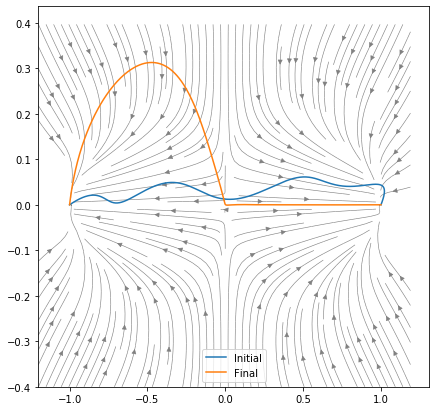

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# The points at which the paths should be evaluates
us = np.linspace(-1, 1, 1000)

# Plot the initial path
_a = action.get_alpha_with_endpoints(alpha0)
xs = pyritz.interpolation.utils.interpolate(_a, n, us)
plt.plot(xs[0,:], xs[1,:], label="Initial")

# Plot the instanton
_a = action.get_alpha_with_endpoints(alpha)
xs = pyritz.interpolation.utils.interpolate(_a, n, us)
plt.plot(xs[0,:], xs[1,:], label="Final")

# Plot the a Stream Plot of the drift
X, Y = np.meshgrid(np.linspace(-1.2,1.2,64), np.linspace(-0.4,.4,64))
sax,say=system_a([X,Y]); sax=sax/np.sqrt(sax**2+say**2); say=say/np.sqrt(sax**2+say**2)
plt.streamplot(X,Y, sax, say, density=1.7, linewidth=.6, color='gray');
plt.legend()

# Set the figure size
fig = mpl.pyplot.gcf()
fig.set_size_inches(7, 7)

There are two functions that need to be explained in the above:

1. `action.get_alpha_with_endpoints(alpha)`

    - This function returns the parameterisation variables with the end-points added.
    
2. `pyritz.interpolation.utils.interpolate(alpha, n, us)`

    - Returns an array of shape `(dim, np.size(us))`, and contains the evaluations of the Barycentric formula at the times `us`.

## References

1. *Ritz method for transition paths and quasipotentials of rare diffusive events.* L. T. Kikuchi, R. Singh, M. E. Cates, R. Adhikari (To be published)

2. *A scaling theory of bifurcations in the symmetric weak-noise escape problem.* R. S. Maier and D. L. Stein, Journal of Statistical Physics 83, 291 (1996)

3. *The geometric minimum action method: A least action principle on the space of curves*. M. Heymann and E. Vanden-Eijnden, Communications on Pure and Applied Mathematics 61, 1052 (2008)

4. *Barycentric Lagrange Interpolation*. J. Berrut and L. N. Trefethen, SIAM review 46, 501 (2004)